# Concatenation of WHOI UOP mooring data records

What I want to do here is to load in multiple WHOI ORS buoy files (from our WHOI server at uop.whoi.edu) and build a merged data set of surface currents.

@jtomfarrar, jfarrar@whoi.edu


In [4]:
import numpy as np
# from netCDF4 import Dataset
from netCDF4 import num2date
import matplotlib.pyplot as plt
import matplotlib as mplt
# from scipy import signal
import datetime
# import nc_time_axis
import xarray as xr
import glob

# for reading data files from uop.whoi.edu
from bs4 import BeautifulSoup
import requests

In [5]:
%matplotlib inline
# %matplotlib qt5
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 700

In [6]:
# This cell reads html page 'directory listing' and parses to get list of files
# uses code snippet from https://stackoverflow.com/questions/11023530/python-to-list-http-files-and-directories

url = 'http://uop.whoi.edu/currentprojects/Stratus/data/vel/'
ext = 'nc'

def listFD(url, ext=''):
    page = requests.get(url).text
    # print(page)
    soup = BeautifulSoup(page, 'html.parser')
    return [url  + node.get('href')  + '#bytes' for node in soup.find_all('a') if node.get('href').endswith(ext)]

filelist = []
i = 0
for file in listFD(url, ext):
    # print(file)
    filelist.append(file)
    i=+i

In [7]:
filelist

['http://uop.whoi.edu/currentprojects/Stratus/data/vel/OS_Stratus_2000_D_surfV.nc#bytes',
 'http://uop.whoi.edu/currentprojects/Stratus/data/vel/OS_Stratus_2001_D_surfV.nc#bytes',
 'http://uop.whoi.edu/currentprojects/Stratus/data/vel/OS_Stratus_2002_D_surfV.nc#bytes',
 'http://uop.whoi.edu/currentprojects/Stratus/data/vel/OS_Stratus_2003_D_surfV.nc#bytes',
 'http://uop.whoi.edu/currentprojects/Stratus/data/vel/OS_Stratus_2004_D_surfV.nc#bytes',
 'http://uop.whoi.edu/currentprojects/Stratus/data/vel/OS_Stratus_2005_D_surfV.nc#bytes',
 'http://uop.whoi.edu/currentprojects/Stratus/data/vel/OS_Stratus_2006_D_surfV.nc#bytes',
 'http://uop.whoi.edu/currentprojects/Stratus/data/vel/OS_Stratus_2007_D_surfV.nc#bytes',
 'http://uop.whoi.edu/currentprojects/Stratus/data/vel/OS_Stratus_2008_D_surfV.nc#bytes',
 'http://uop.whoi.edu/currentprojects/Stratus/data/vel/OS_Stratus_2010_D_surfV.nc#bytes',
 'http://uop.whoi.edu/currentprojects/Stratus/data/vel/OS_Stratus_2011_D_surfV.nc#bytes',
 'http://u

In [8]:
# 1 = xr.open_dataset(filelist[0])
# 1

In [9]:
# Read in all the files in the list
# This would be nicer done as xr.open_mfdataset, but that doesn't work well because depth, lat, and lon changes between records
datasets = [] # we will build a list of xarray datasets
for i in range(np.max(np.shape(filelist))):
    ds1 = xr.open_dataset(filelist[i])
    datasets.append(ds1)

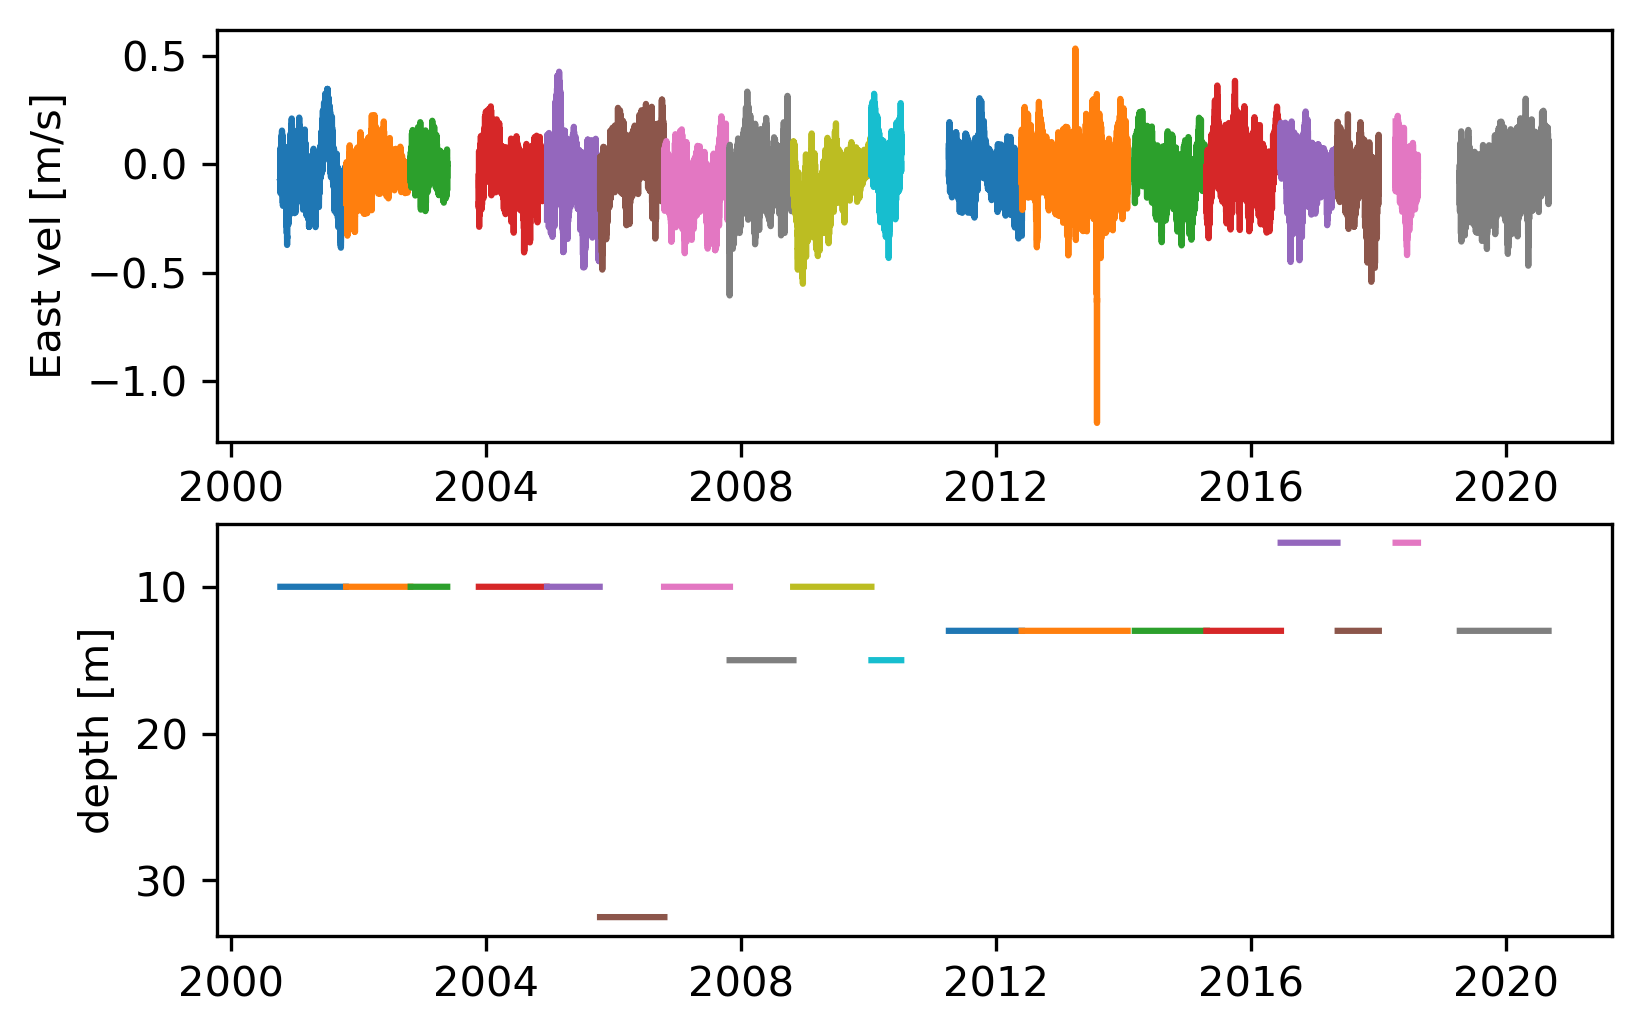

In [10]:
fig = plt.figure(figsize=(6,4))
sp1 = plt.subplot(2,1,1)
sp2 = plt.subplot(2,1,2)
for i in range(np.max(np.shape(filelist))):
    sp1.plot(datasets[i].TIME,datasets[i].UCUR)
    sp2.plot(datasets[i].TIME,0*datasets[i].UCUR+datasets[i].DEPTH)

sp2.invert_yaxis()
plt.subplot(sp2)
plt.ylabel('depth [m]')
plt.subplot(sp1)
plt.ylabel('East vel [m/s]');

## Based on the plot above, I would recommend going for April 2011-June 2016 and Sep 2000-May 2003
(There is a ~6 week gap around Feb 2014.)

In [11]:
files = filelist[0:2]
dsmerge=xr.open_mfdataset(files, combine='nested', concat_dim='TIME')

In [12]:
dsmerge

<xarray.Dataset>
Dimensions:    (DEPTH: 1, LATITUDE: 2, LONGITUDE: 2, TIME: 141449)
Coordinates:
  * LATITUDE   (LATITUDE) float64 -20.15 -20.14
  * LONGITUDE  (LONGITUDE) float64 -85.15 -85.14
  * TIME       (TIME) datetime64[ns] 2000-10-07T22:07:30 ... 2002-10-22T12:52...
  * DEPTH      (DEPTH) float64 10.0
Data variables:
    UCUR       (TIME, DEPTH) float64 dask.array<chunksize=(70857, 1), meta=np.ndarray>
    VCUR       (TIME, DEPTH) float64 dask.array<chunksize=(70857, 1), meta=np.ndarray>
    CDIR       (TIME, DEPTH) float64 dask.array<chunksize=(70857, 1), meta=np.ndarray>
    CSPD       (TIME, DEPTH) float64 dask.array<chunksize=(70857, 1), meta=np.ndarray>
    TEMP       (TIME, DEPTH) float64 dask.array<chunksize=(70857, 1), meta=np.ndarray>
    MAGVAR     (TIME) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    INST       (TIME) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
Attributes:
    data_type:                     OceanSites time-series data
    Conventions:                   CF 1.6, OceanSITES-1.2
    netcdf_version:                3.5
    format_version:                1.2
    institution:                   WHOI
    source:                        Mooring observation
    naming_authority:              OceanSITES
    cdm_data_type:                 Station
    data_assembly_center:          WHOI-UOP
    distribution_statement:         Follows CLIVAR (Climate Varibility and Pr...
    license:                        Follows CLIVAR (Climate Varibility and Pr...
    institution_references:        http://uop.whoi.edu
    keywords_vocabulary:           AGU Index Terms
    keywords:                       OCEANOGRAPHY: PHYSICAL -> Currents
    keywords_vocabulary_URL:       http://mmisw.org/orr/#http://mmisw.org/ont...
    standard_name_vocabulary:      CF-v35
    site_code:                     Stratus
    title:                         Stratus 1 surface velocity data 
    project:                       Stratus
    platform_code:                 Stratus
    wmo_platform_code:             38400
    deployment_number:             1
    deployment_code:               2000
    id:                            OS_Stratus_2000_D_surfV
    summary:                       Delayed mode near-surface velocity data fr...
    references:                    http://uop.whoi.edu/projects/stratus, http...
    citation:                      Data from the Stratus Ocean Reference Stat...
    acknowledgement:               Support for this research was provided by ...
    creator_name:                  Robert Weller
    creator_url:                   http://www.whoi.edu/profile/rweller/
    creator_email:                 RWeller AT WHOI.edu
    principal_investigator:        Robert Weller
    author:                        WHOI Upper Ocean Processes Group (N. Galbr...
    contact:                       WHOI Upper Ocean Processes Group (N. Galbr...
    publisher_name:                WHOI Upper Ocean Processes Group (N. Galbr...
    publisher_url:                 http://uop.whoi.edu http://www.whoi.edu/pr...
    publisher_email:               UOP_DM@whoi.edu
    contributor_name:              Kelan Huang, Nan Galbraith
    contributor_role:              Quality control and editing, OceanSITES co...
    date_created:                  2016-10-20T09:49:46Z
    date_modified:                 2016-10-20T09:49:46Z
    date_issued:                   2009-12-10T00:00:00Z
    date_update:                   2016-10-20T09:49:46Z
    update_interval:               void
    history:                       Data despiked, cals checked, directions co...
    comment:                       Internally recorded surface velocity data ...
    data_mode:                     D
    Metadata_Link:                 http://uop.whoi.edu/projects/Stratus/OS_St...
    quality_index:                 excellent
    quality_control_procedure:     Data manually reviewed, clock drift corrected
    QC_flag_values:                [0. 1. 2. 3. 4.]
    QC_flag_meanings

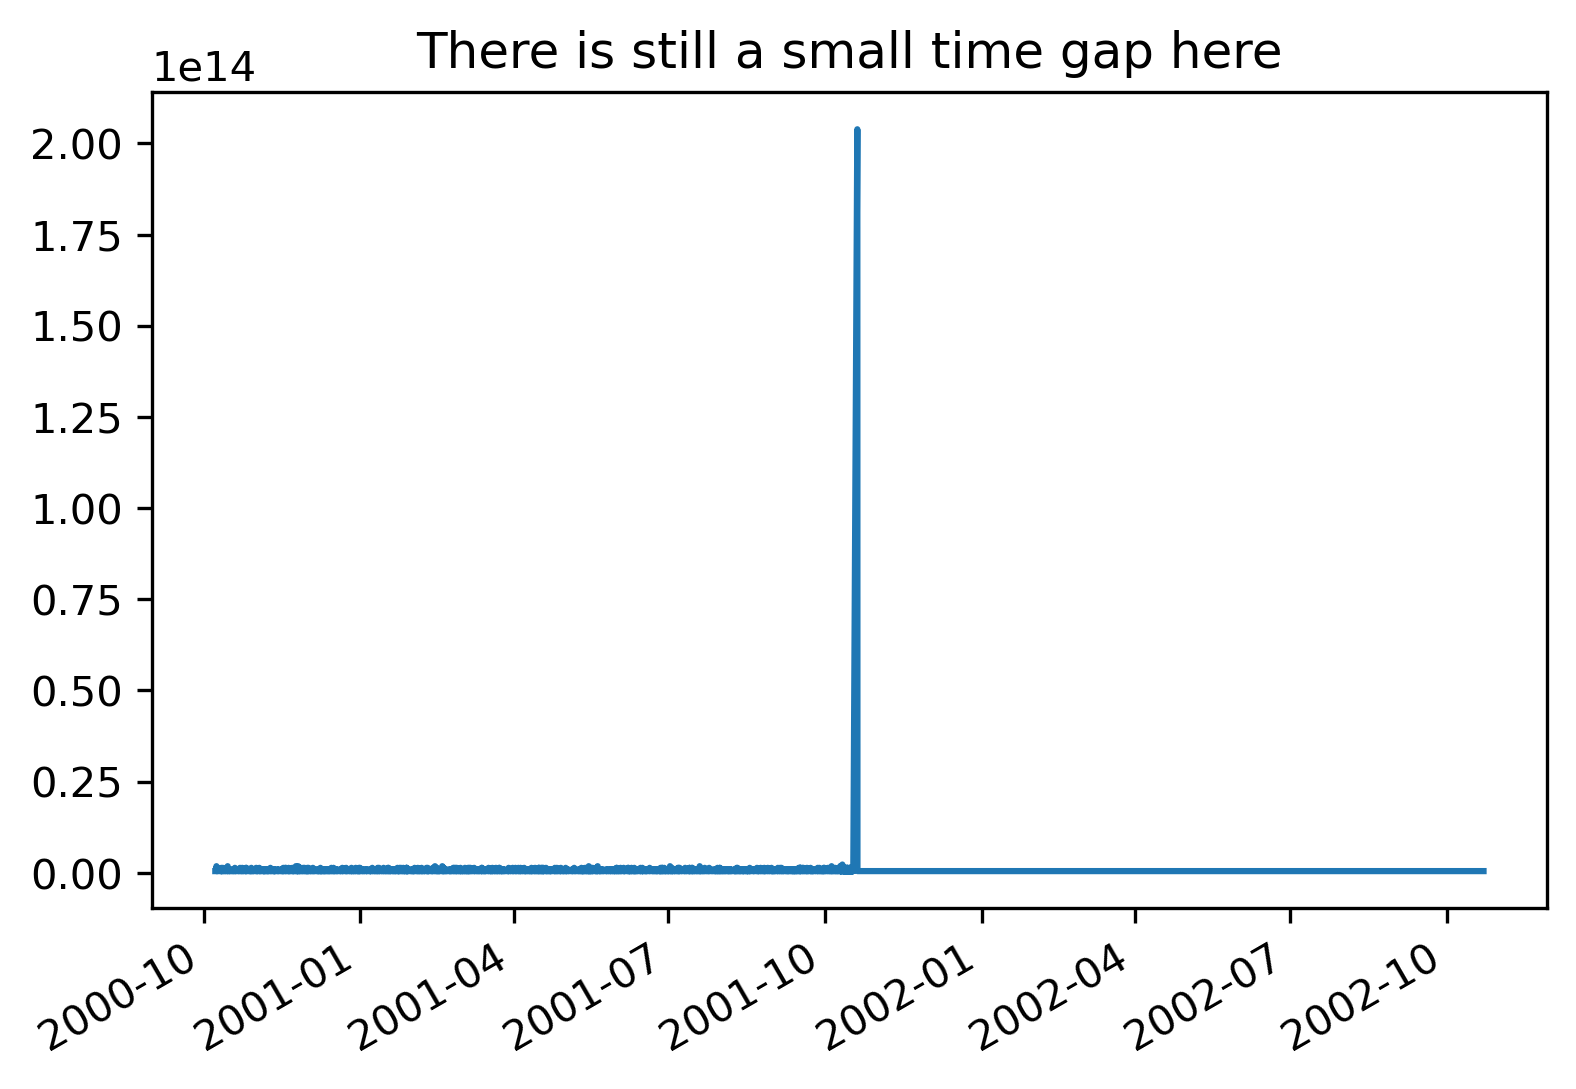

In [13]:
fig = plt.figure(figsize=(6,4))
plt.plot(dsmerge.TIME[1:],np.diff(dsmerge.TIME))
plt.title('There is still a small time gap here')
fig.autofmt_xdate()